#**Vietnamese Toxic Detect System with Pyspark**
Phát hiện nội dung độc hại bằng tiếng Việt với Pyspark

Tiểu luận môn học **Dữ liệu lớn**

---

**Họ và tên SV 1:** Nguyễn Thành Phát

**MSSV SV 1:** 2000006273

---

**Họ và tên SV 2:** Nguyễn Minh Trí

**MSSV SV 2:** 2000000054

---

##(Nhấn Crtl + F9 để chạy tất cả)

In [ ]:
!pip install pyspark handyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=a77836080dfb5451d305e7832ed992826e8b4bfc8571bc73f4e3e07e157764f6
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
# Download dataset
!gdown 1CriqmsH9MzKn9k78x9GvnH5UTAg3GBIF
!gdown 1RyAZ_vpO2sndK9ZTvJLenVMPcnIwJuhh
!wget https://github.com/phusroyal/ViHOS/raw/master/data/Span_Extraction_based_version/train.csv
!wget https://github.com/phusroyal/ViHOS/raw/master/data/Test_data/test.csv

Downloading...
From: https://drive.google.com/uc?id=1CriqmsH9MzKn9k78x9GvnH5UTAg3GBIF
To: /content/negative_data.csv
100% 864k/864k [00:00<00:00, 27.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RyAZ_vpO2sndK9ZTvJLenVMPcnIwJuhh
To: /content/positive_data.csv
100% 1.12M/1.12M [00:00<00:00, 24.4MB/s]
--2023-09-05 14:33:24--  https://github.com/phusroyal/ViHOS/raw/master/data/Span_Extraction_based_version/train.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/phusroyal/ViHOS/master/data/Span_Extraction_based_version/train.csv [following]
--2023-09-05 14:33:25--  https://raw.githubusercontent.com/phusroyal/ViHOS/master/data/Span_Extraction_based_version/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuse

In [ ]:
# Import thư viện
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [ ]:
# Tạo Session hoạt động cho project
spark = SparkSession.builder.appName("ToxicTextClassification").getOrCreate()

In [ ]:
df_vihos = spark.read.csv("train.csv", header=True, inferSchema=True)

In [ ]:
df_vihos.describe().show()

+-------+--------------------+-------+--------------------+
|summary|                 _c0|content|         index_spans|
+-------+--------------------+-------+--------------------+
|  count|                8853|   8850|                8838|
|   mean|              4421.5|   null|                10.0|
| stddev|  2553.1872238439546|   null|                null|
|    min|- ""có lẽ bạn kg ...|    !!!| ""DN Việt đóng n...|
|    max|Tàu ác hơn Mỹ tră...| 🥰🥰🥰|ơn chính phủ...""...|
+-------+--------------------+-------+--------------------+



In [ ]:
df_vihos_test = spark.read.csv("test.csv", header=True, inferSchema=True)

In [ ]:
df_vihos_test.describe().show()

+-------+--------------------+--------------------+--------------------+
|summary|                 _c0|             content|         index_spans|
+-------+--------------------+--------------------+--------------------+
|  count|                1107|                1107|                1105|
|   mean|               552.5|                null|                null|
| stddev|   319.4190038178693|                null|                null|
|    min|                   0|"Bố lạy mày đừng ...| bị bọn Mỹ ""Ngụy...|
|    max|Sau này mụ chết c...|            🤣🤣🤣🤣|                  []|
+-------+--------------------+--------------------+--------------------+



In [ ]:
df_vihos.show()

+---+--------------------+--------------------+
|_c0|             content|         index_spans|
+---+--------------------+--------------------+
|  0|         Dừa lắm :))|                  []|
|  1|     Bấp bênh vl thế|             [9, 10]|
|  2|Chắc cũng biết ko...|        [53, 54, 55]|
|  3|Thấy chán ad page...|[5, 6, 7, 8, 36, ...|
|  4|Giang Giang Đỗ Th...|                  []|
|  5|đcm 😒 sau có con...|[0, 1, 2, 4, 21, ...|
|  6|  Má nứng quá aiu ơi|  [0, 1, 3, 4, 5, 6]|
|  7|Chụp cái ảnh thôi...|        [22, 23, 24]|
|  8|Tăng theo giờ 😭😭😭|                  []|
|  9|Cực kì thuyết phụ...|                  []|
| 10|Emma Nguyen vậy m...|        [49, 50, 51]|
| 11|           Thằng chó|[0, 1, 2, 3, 4, 5...|
| 12|Loại nghiện game ...|[0, 1, 2, 3, 4, 5...|
| 13|Nhung Pham Ai chê...|[52, 53, 65, 66, ...|
| 14|toàn tin vớ vẩn ....|[109, 110, 111, 1...|
| 15|Ủa bê đê có lol h...|[3, 4, 5, 6, 7, 1...|
| 16|Kéo chuột vãi lồn...|[10, 11, 12, 13, ...|
| 17|Mỗi lần lên sóng ...|[29, 30, 31, 32, .

## **Tiền xử lý dữ liệu**

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType,IntegerType
# Xoá data bị null
df_vihos = df_vihos.dropna()
# Chuyển index_spans thành dạng nhãn đơn giản
# 1 tương ứng với độc hại, 0 thì không
def convertToLabel(x):
    return 0 if len(str(x))>2 else 1

df_vihos_withLabel = df_vihos.withColumn("Label", udf(convertToLabel,StringType())("index_spans"))
# Xoá cột này đi vì không cần dùng nữa, và cột chỉ mục _c0
df_vihos_withLabel = df_vihos_withLabel.drop("index_spans","_c0")
# Với tập test đi kèm cũng làm tương tự
df_vihos_test = df_vihos_test.withColumn("Label", udf(convertToLabel,StringType())("index_spans"))

In [ ]:
df_vihos_withLabel.show()

+--------------------+-----+
|             content|Label|
+--------------------+-----+
|         Dừa lắm :))|    1|
|     Bấp bênh vl thế|    0|
|Chắc cũng biết ko...|    0|
|Thấy chán ad page...|    0|
|Giang Giang Đỗ Th...|    1|
|đcm 😒 sau có con...|    0|
|  Má nứng quá aiu ơi|    0|
|Chụp cái ảnh thôi...|    0|
|Tăng theo giờ 😭😭😭|    1|
|Cực kì thuyết phụ...|    1|
|Emma Nguyen vậy m...|    0|
|           Thằng chó|    0|
|Loại nghiện game ...|    0|
|Nhung Pham Ai chê...|    0|
|toàn tin vớ vẩn ....|    0|
|Ủa bê đê có lol h...|    0|
|Kéo chuột vãi lồn...|    0|
|Mỗi lần lên sóng ...|    0|
|Làm thêm chục củ ...|    1|
|Hãnh diện về ng t...|    1|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Lấy data từ 2 tập dữ liệu đánh giá tích cực và tiêu cực
df_ne = spark.read.csv("negative_data.csv", header=True, inferSchema=True)
df_po = spark.read.csv("positive_data.csv", header=True, inferSchema=True)
# Nối 2 DataFrame thành 1 bộ DataFrame duy nhất
df = df_ne.union(df_po).dropDuplicates()


In [ ]:
df.describe().show()

+-------+------------------+--------------------+-------------------+
|summary|              Rate|              Review|              Label|
+-------+------------------+--------------------+-------------------+
|  count|              4391|                4391|               4391|
|   mean| 6.739330448645003|                null| 0.5980414484172171|
| stddev|3.3021149304670567|                null|0.49034950030585467|
|    min|               1.0| #NGẮM_PHÁO_HOA_T...|                  0|
|    max|              10.0|" Nhà hàng Neverl...|                  1|
+-------+------------------+--------------------+-------------------+



In [ ]:
# Xem 5 dòng đầu tiên
df.show(5)

+----+--------------------+-----+
|Rate|              Review|Label|
+----+--------------------+-----+
| 3.4| Mình gọi chảo pa...|    0|
| 3.2| Quán nằm ở mặt đ...|    0|
| 2.2| Nếu không muốn ă...|    0|
| 3.2| Nửa năm k tới qu...|    0|
| 2.4| Eo tưởng hình th...|    0|
+----+--------------------+-----+
only showing top 5 rows



In [ ]:
# Xoá cột Rate vì không cần thiết
df = df.drop("Rate")
# Đổi tên cột Review thành content cho đồng bộ giữa 2 datasets
df = df.withColumnRenamed("Review","content")
# Nối 2 dataset thành 1
df = df.union(df_vihos_withLabel)

In [ ]:
# Xáo trộn dữ liệu
import pyspark.sql.functions as F
df = df.select("*").orderBy(F.rand())

In [ ]:
df = df.withColumn("content", df["content"].cast(StringType()))
df = df.withColumn("Label", df["Label"].cast(IntegerType()))

In [ ]:
df

DataFrame[content: string, Label: int]

In [ ]:
df.show()

+--------------------+-----+
|             content|Label|
+--------------------+-----+
|Quân Anh dơ nhưng...|    1|
|Phòng ốc sạch sẽ ...|    1|
|Cái này xảy ra ho...|    1|
|              bts cc|    0|
|Ba nay rah wa luc...|    0|
| MÌNH ĐÃ ĐƯA GIA ...|    1|
| Mình không thích...|    0|
|K icm ca sĩ concac à|    0|
|          Trần Thành|    1|
| Thực sự là không...|    0|
| Cheese cheese ko...|    1|
|        Cc j zay :))|    0|
|Giọng anh trung B...|    0|
|                  🙃|    1|
| Ăn vị ướp công n...|    0|
|               Ừ OKE|    1|
| Khách ruột của q...|    1|
|Đang Ôn Thi Tuyết...|    0|
|Nguyễn Bảo Nguyen...|    1|
|        khi k con vb|    1|
+--------------------+-----+
only showing top 20 rows



/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


<Axes: title={'center': 'Label'}, xlabel='Label'>

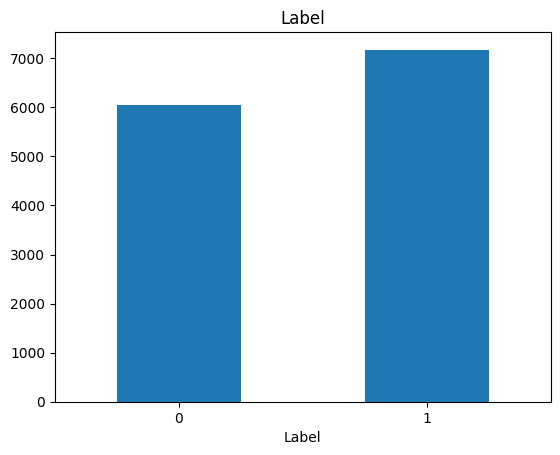

In [ ]:
# Show biểu đồ phân bố dữ liệu
from handyspark import *
hdf = df.toHandy()
hdf.cols["Label"].hist()

In [ ]:
# Lấy một điểm dữ liệu
df.take(1)

[Row(content='Quân Anh dơ nhưng kích thích', Label=1)]

## **Xây dựng và huấn luyện mô hình**

In [ ]:
# Tạo các hàm chuyển đổi dữ liệu để có thể tích hợp vào "đường ống" (Pipeline)
tokenizer = Tokenizer(inputCol="content", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [ ]:
# Áp dụng mô hình hồi quy Logistic
lr = LogisticRegression(featuresCol="features", labelCol="Label")
# Tạo đường ống (pineline) truyền từ xử lý dữ liệu đến model
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])
# Training mô hình
model = pipeline.fit(df)


## **Kiểm thử kết quả và dự đoán**

In [ ]:
# Lấy kết quả dự đoán trên tập test_vihos
df_vihos_test = df_vihos_test.withColumn("Label", df_vihos_test["Label"].cast(IntegerType()))
predictions_vihos = model.transform(df_vihos_test)

In [ ]:
predictions_vihos.show(5)

+---+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|_c0|             content|         index_spans|Label|               words|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  0|           Anh bar .|                  []|    1|       [anh, bar, .]|(262144,[45404,11...|(262144,[45404,11...|[-42.545656809566...|[3.33162428159463...|       1.0|
|  1|          Hello thầy|                  []|    1|       [hello, thầy]|(262144,[217366,2...|(262144,[217366,2...|[-73.709939070962...|[9.73150925602398...|       1.0|
|  2|Từ lúc mấy bro cm...|            [26, 27]|    0|[từ, lúc, mấy, br...|(262144,[9408,152...|(262144,[9408,152...|[111.102602157338...|           [1

In [ ]:
# Phân tích AUC (True Positive Rate, TPR)
# (Tỉ lệ dự đoán đúng trên nhãn thực tế)
evaluator = BinaryClassificationEvaluator(labelCol="Label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions_vihos)
print("Area under ROC(vihos datasets):", auc)
y_true = df_vihos_test.select("Label").collect()
y_pred = predictions_vihos.select("prediction").collect()

# In Confusion matrix (Ma trận lầm lẫn)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

Area under ROC(vihos datasets): 0.871423667865317
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       532
           1       0.81      0.80      0.81       575

    accuracy                           0.80      1107
   macro avg       0.80      0.80      0.80      1107
weighted avg       0.80      0.80      0.80      1107



In [ ]:
# Xây dựng hàm dự đoán văn bản
def IsToxicVietnameseText(text):
  single_text_df = spark.createDataFrame([(text,)], ["content"])
  predict = model.transform(single_text_df)
  probability = list(predict.select("probability").collect()[0]["probability"])
  isToxic = predict.select("prediction").collect()[0]["prediction"] == 0
  return ({"negative":round(probability[0],2),"positive":round(probability[1],2)},isToxic)

In [ ]:
# Ví dụ dự đoán nhãn "tích cực"
IsToxicVietnameseText("Chất cotton siêu đẹp mịn mát.")

({'negative': 0.0, 'positive': 1.0}, False)

In [ ]:
# Ví dụ dự đoán nhãn "tiêu cực"
IsToxicVietnameseText("Dịch vụ quá tệ !")

({'negative': 1.0, 'positive': 0.0}, True)

In [ ]:
model.save("VietnameseToxicDetect")

## **Xây dựng giao diện sử dụng**

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 7.4 MB/s eta 0:0

In [ ]:
# Tạo giao diện sử dụng
import gradio as gr

def sentiment_analysis(text):
    predict = IsToxicVietnameseText(text)
    scores = predict[0]
    return scores

demo = gr.Interface(
    fn=sentiment_analysis,
    inputs=gr.Textbox(placeholder="Nhập văn bản tại đây...",label="Hệ thống kiểm tra nội dung độc hại!"),
    outputs="label",
    examples=[["Tuyệt vời!"],["Dịch vụ quá tệ !"],["Quán ăn ngon"],["Im đi đồ ngu!"]])

demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
# Kết thúc session khi đã sử dụng xong
# spark.stop()